In [ ]:
pip install pytorch-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 55.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, f1_score, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_transformers import AdamW
from transformers import BertForSequenceClassification,BertTokenizer
from keras.utils import pad_sequences

from tqdm import tqdm,trange
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Загрузим датафрейм, полученный с помощью collect_data_hh:

In [ ]:
import pandas as pd
data = pd.read_csv('/kaggle/input/cv-final/cv_for_bert_final.csv')
data

,id_candidate,id_cv,position_name,industry_code,skills,additional_skills,other_info,profession_code,faculty,qualification,speciality,job_title,demands,hh_names
0,9cf5ef50-a4c4-11ea-a935-bfd13399602c,ed8b0a20-b20e-11ea-a14f-037acc02728d,оператор тигельный вырубной пресс,Industry,усидчивая склонный монотонный кропотливый работа,готовый работать человек деньга,хотеться найти работа сменный дневный график,NaN,издательский дело,специалист издательский дело,NaN,работник клише оператор тигельный машина опера...,работа тампопечатной машина тиснение постановк...,NaN
1,730447e0-92bf-11e9-8af8-e37b4be0b9ed,a04fab70-92c1-11e9-8af8-e37b4be0b9ed,инженер конструктор,Industry,знание основа система автоматизированный проек...,NaN,NaN,224914.0,аэрокосмический,инженер,NaN,NaN,NaN,NaN
2,cff06eb0-b7d1-11ea-9f0b-bfd13399602c,eb148250-b955-11ea-9238-736ab11edb0c,электрогазосварщик,Industry,NaN,NaN,NaN,197562.0,NaN,разряд,электогазосварщик газорезчик,NaN,NaN,Сварщик
3,3806fd60-a653-11ea-b45a-7bf9d8e248ac,386bdce0-a657-11ea-9353-1fdc17069750,машинист кран крановщик,MechanicalEngineering,NaN,NaN,NaN,NaN,очный,машинист кран автомобильный,машинист кран крановщик,NaN,NaN,NaN
4,638afdc0-a81e-11ea-b45a-7bf9d8e248ac,55018090-b09c-11ea-98a0-736ab11edb0c,оператор станок чпу,Metallurgy,NaN,NaN,NaN,191496.0,NaN,NaN,NaN,рабочий,работа станок измерение диталий,Оператор станков с ЧПУ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430616,4bde9760-8aed-11e6-af05-0f468c90bfa7,82bab5f7-8aef-11e6-af05-0f468c90bfa7,администратор воспитатель секретарь водитель,Industry,NaN,NaN,NaN,NaN,культура,NaN,специалист связь общественность,NaN,NaN,NaN
430617,14aae080-96a3-11ea-88d8-736ab11edb0c,529e3be0-9995-11ea-b25c-b905beff6f7a,токарь металл разряд,Metallurgy,NaN,NaN,NaN,NaN,NaN,NaN,токарь металл разряд,токарь разряд,механический обработка металл чтение чертёж ис...,"Токарь, фрезеровщик, шлифовщик"
430618,d807ae40-9486-11e7-8e38-ef76bd2a03c1,b645258a-9d32-11e7-9620-4376a32b3f45,инженер технолог,Industry,NaN,NaN,NaN,228544.0,технология машиностроение,инженер технолог,NaN,продавец консультант кладовщик отдел снабжение...,личный продажа консультация товар погрузочный ...,NaN
430619,c2238a10-7a9b-11ea-b248-037acc02728d,d4c675b0-7aa5-11ea-8b61-037acc02728d,столяр маляр,WorkingSpecialties,NaN,NaN,NaN,188741.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cols = ['position_name', 'skills', 'additional_skills', 'other_info', 'faculty',
       'qualification', 'speciality', 'job_title', 'demands']
data[cols] = data[cols].fillna(' ')

Закодируем категории из hh:

In [ ]:
def c(obj):
    global i
    if obj in dct:
        return dct[obj]
    else:
        dct[obj] = i
        i += 1
        return dct[obj]

i = 0
dct = {}
data['label'] = data['hh_names'].apply(c)

Визуализации:

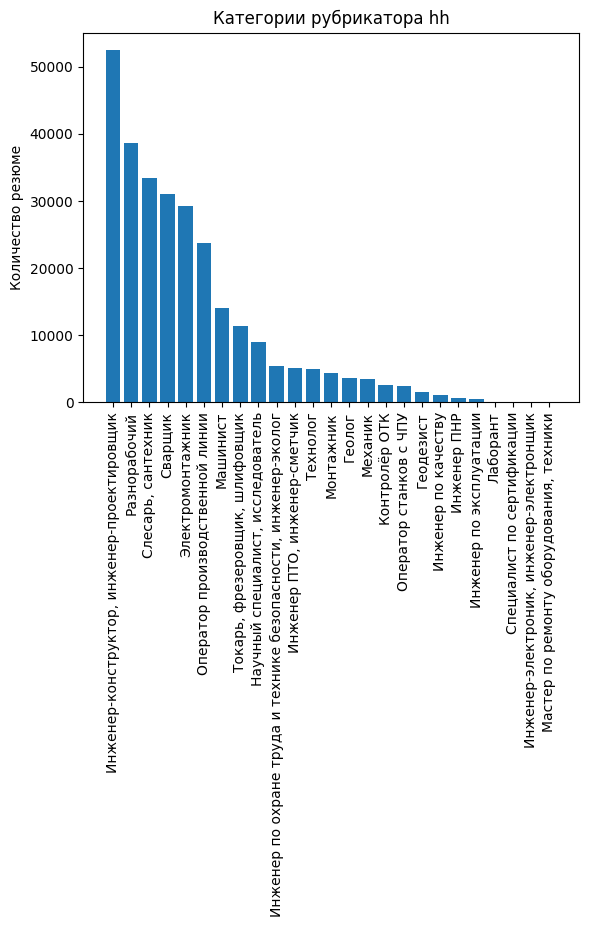

In [ ]:
counts = data['hh_names'].value_counts()
plt.bar(counts.index, counts.values)

plt.title('Категории рубрикатора hh')
plt.xticks(rotation=90)
plt.ylabel('Количество резюме')

plt.show()

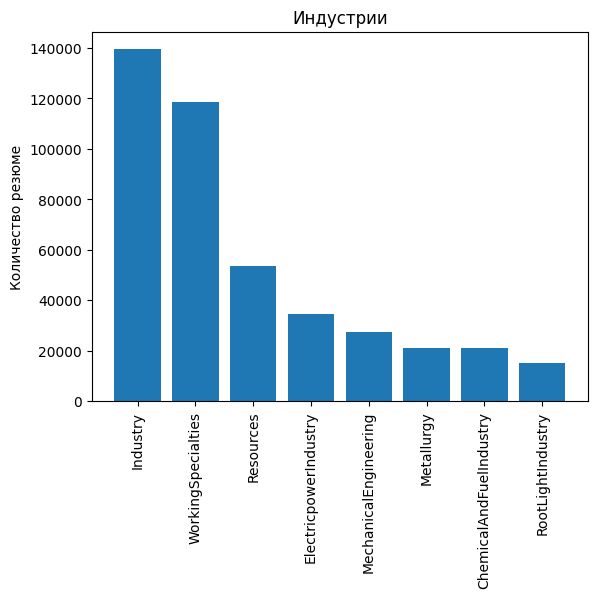

In [ ]:
counts = data['industry_code'].value_counts()
plt.bar(counts.index, counts.values)

plt.title('Индустрии')
plt.xticks(rotation=90)
plt.ylabel('Количество резюме')

plt.show()

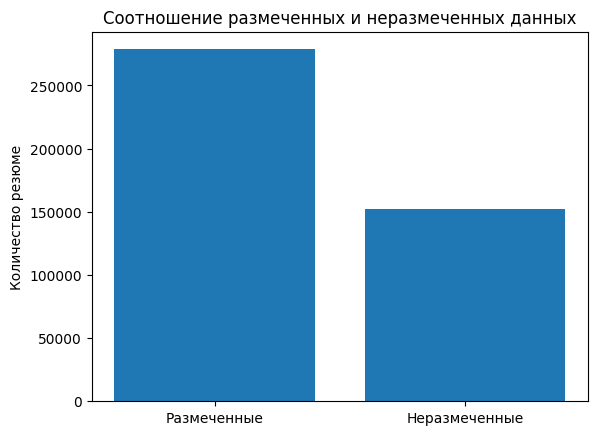

In [ ]:
counts = data['hh_names'].isnull().value_counts()
plt.bar(['Размеченные', 'Неразмеченные'], counts.values)

plt.title('Соотношение размеченных и неразмеченных данных')
plt.ylabel('Количество резюме')

plt.show()

Соединим всю доступную информацию в один текст:

In [ ]:
data['full_description'] = data['position_name'] + ' ' + data['skills'] + ' ' + data['additional_skills'] + ' ' + data['job_title'] + ' ' + data['demands']

Разделим на размеченную и неразмеченную выборки:

In [ ]:
train = data.query('hh_names == hh_names')
train['label'] = train['label'] - 1
for_preds = data.query('hh_names != hh_names')

train.to_csv('jobs_table_processed.csv',index=False)

Инициализируем модель и токенизатор:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_sentences = train['full_description'].values
train_sentences = [' '.join(list(set(sent.split()))) for sent in train_sentences]
train_gt = train['label'].values
train_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in train_sentences]

model=BertForSequenceClassification .from_pretrained('sberbank-ai/ruBert-base', num_labels=25)
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(train_sentences)]
print(tokenized_texts[0])

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not in

100%|██████████| 278625/278625 [05:16<00:00, 880.03it/s]

['[CLS]', 'электро', '##газ', '##ос', '##вар', '##щик', '[SEP]']


Словарь для векторизации и attention masks:

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=200,
    truncating="post",
    padding="post"
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Разделим на тренировочную и валидационную выборки:

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt,
    random_state=42,
    test_size=0.1,
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

Параметры модели:

In [ ]:
model.cuda();
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

Обучение и валидация:

In [ ]:
train_loss_set  = []
train_loss = 0
train_acc_set = []
train_preds = []
train_labels = []

model.train()


for epoch in range(3):
    train_loss = 0
    for step, batch in tqdm(enumerate(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss[0].item())

        logits = loss['logits'].detach().cpu().numpy()
        batch_preds = np.argmax(logits, axis=1)
        train_preds.extend(batch_preds)
        train_labels.extend(b_labels)
        if step % 100 == 0:
            acc =  len([train_preds[i] for i in range(len(train_preds)) if train_preds[i] == train_labels[i]]) / len(train_labels)
            train_acc_set.append(acc)

        loss[0].backward()

        optimizer.step()

        train_loss += loss[0].item()

    print(f"Epoch {epoch+1} Train loss: {train_loss/len(train_dataloader)}")

model.eval()

test_preds, test_labels, test_acc_set = [], [], []

for step, batch in tqdm(enumerate(validation_dataloader)):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids

    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

    if step % 10 == 0:
        acc =  len([test_preds[i] for i in range(len(test_preds)) if test_preds[i] == test_labels[i]]) / len(test_labels)
        test_acc_set.append(acc)

7837it [1:20:43,  1.62it/s]


Epoch 1 Train loss: 0.4651603520537337


7837it [1:30:17,  1.45it/s]


Epoch 2 Train loss: 0.31787103207427064


7837it [1:39:46,  1.31it/s]


Epoch 3 Train loss: 0.26790220847100693


871it [02:43,  5.31it/s]


Text(0.5, 1.0, 'Loss тренировочной выборке')

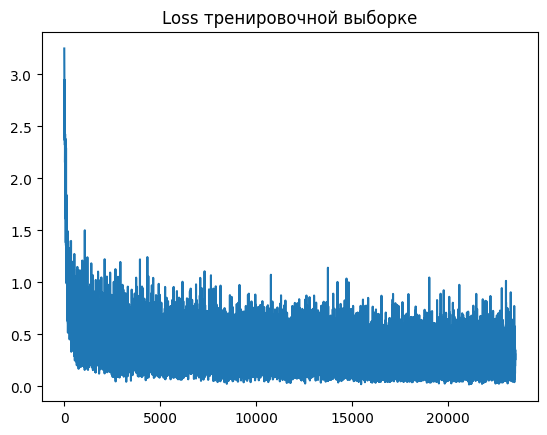

In [ ]:
plt.plot(train_loss_set)
plt.title('Loss тренировочной выборке')

Text(0.5, 1.0, 'Accuracy на тренировочной выборке')

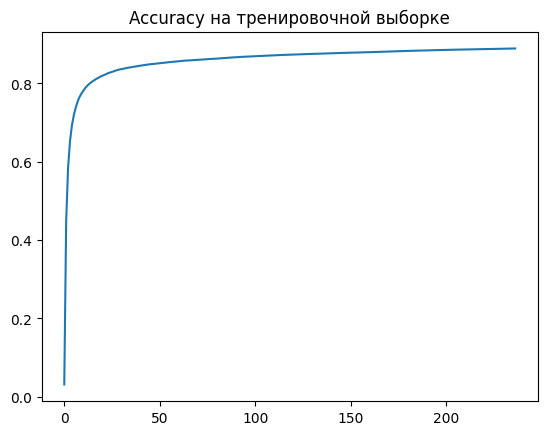

In [ ]:
plt.plot(train_acc_set)
plt.title('Accuracy на тренировочной выборке')

In [ ]:
res = pd.DataFrame(zip(test_preds, test_labels), columns=['predictions','label'])
print(f'Acurracy на отложенной выборке:{res.query("predictions == label").shape[0]/res.shape[0]}')

Acurracy на отложенной выборке:0.8930840182320641


In [ ]:
test_sentences = for_preds['full_description'].values
train_sentences = [' '.join(list(set(sent.split()))) for sent in train_sentences]
train_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in train_sentences]

tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=200,
    truncating="post",
    padding="post"
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks
)

prediction_dataloader = DataLoader(
    prediction_data,
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)
model.eval()

test_preds = []

for batch in tqdm(prediction_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    batch_preds = np.argmax(logits, axis=1)
    test_preds.extend(batch_preds)

100%|██████████| 4750/4750 [14:50<00:00,  5.33it/s]


In [ ]:
for_preds['label'] = test_preds
for_preds

,id_candidate,id_cv,position_name,industry_code,skills,additional_skills,other_info,profession_code,faculty,qualification,speciality,job_title,demands,hh_names,label,full_description
0,9cf5ef50-a4c4-11ea-a935-bfd13399602c,ed8b0a20-b20e-11ea-a14f-037acc02728d,оператор тигельный вырубной пресс,Industry,усидчивая склонный монотонный кропотливый работа,готовый работать человек деньга,хотеться найти работа сменный дневный график,NaN,издательский дело,специалист издательский дело,,работник клише оператор тигельный машина опера...,работа тампопечатной машина тиснение постановк...,NaN,6,оператор тигельный вырубной пресс усидчивая ск...
1,730447e0-92bf-11e9-8af8-e37b4be0b9ed,a04fab70-92c1-11e9-8af8-e37b4be0b9ed,инженер конструктор,Industry,знание основа система автоматизированный проек...,,,224914.0,аэрокосмический,инженер,,,,NaN,5,инженер конструктор знание основа система авто...
3,3806fd60-a653-11ea-b45a-7bf9d8e248ac,386bdce0-a657-11ea-9353-1fdc17069750,машинист кран крановщик,MechanicalEngineering,,,,NaN,очный,машинист кран автомобильный,машинист кран крановщик,,,NaN,3,машинист кран крановщик
6,504b8ec0-bb10-11e8-82be-e37b4be0b9ed,0e90c6c0-d06a-11e8-b75d-037acc02728d,облицовщик плиточник,WorkingSpecialties,умение согласовать работать коллектив,дисциплинированность ответственность,,152203.0,,,,,,NaN,8,облицовщик плиточник умение согласовать работа...
10,7621f110-7fdc-11ea-9d6e-ef76bd2a03c1,d26fa440-8012-11ea-b2aa-037acc02728d,швея закройщик,Industry,,коммуникабельность трудолюбие порядочность,,169098.0,портной женский лёгкий одежда,портной,портной разряд,швея,выполнение индивидуальный массовый швейный заказ,NaN,18,швея закройщик коммуникабельность трудолюбие...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430614,c7823360-b0ca-11e6-ab05-037acc02728d,cfa32ff0-dda9-11e8-9a22-ef76bd2a03c1,слесарь электрик ремонт электрооборудование,ElectricpowerIndustry,разряд,,,NaN,,слесарь электрик,слесарь электрик ремонт электрооборудование,,,NaN,11,слесарь электрик ремонт электрооборудование ра...
430616,4bde9760-8aed-11e6-af05-0f468c90bfa7,82bab5f7-8aef-11e6-af05-0f468c90bfa7,администратор воспитатель секретарь водитель,Industry,,,,NaN,культура,,специалист связь общественность,,,NaN,5,администратор воспитатель секретарь водитель ...
430618,d807ae40-9486-11e7-8e38-ef76bd2a03c1,b645258a-9d32-11e7-9620-4376a32b3f45,инженер технолог,Industry,,,,228544.0,технология машиностроение,инженер технолог,,продавец консультант кладовщик отдел снабжение...,личный продажа консультация товар погрузочный ...,NaN,5,инженер технолог продавец консультант клад...
430619,c2238a10-7a9b-11ea-b248-037acc02728d,d4c675b0-7aa5-11ea-8b61-037acc02728d,столяр маляр,WorkingSpecialties,,,,188741.0,,,,,,NaN,4,столяр маляр


In [ ]:
new_dict = {
    0: 'Сварщик',
    1: 'Оператор станков с ЧПУ',
    2: 'Контролёр ОТК',
    3: 'Машинист',
    4: 'Слесарь, сантехник',
    5: 'Инженер-конструктор, инженер-проектировщик',
    6: 'Оператор производственной линии',
    7: 'Монтажник',
    8: 'Разнорабочий',
    9: 'Токарь, фрезеровщик, шлифовщик',
    10: 'Инженер по эксплуатации',
    11: 'Электромонтажник',
    12: 'Геолог',
    13: 'Инженер ПТО, инженер-сметчик',
    14: 'Механик',
    15: 'Научный специалист, исследователь',
    16: 'Инженер ПНР',
    17: 'Инженер по качеству',
    18: 'Технолог',
    19: 'Геодезист',
    20: 'Инженер по охране труда и технике безопасности, инженер-эколог',
    21: 'Лаборант',
    22: 'Специалист по сертификации',
    23: 'Инженер-электроник, инженер-электронщик',
    24: 'Мастер по ремонту оборудования, техники'
    }
for_preds['hh_names'] = for_preds['label'].replace(new_dict)

In [ ]:
final_df = pd.concat([train, for_preds]).reset_index(drop=True)

In [ ]:
final_df.to_csv('final_df.csv')

In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)